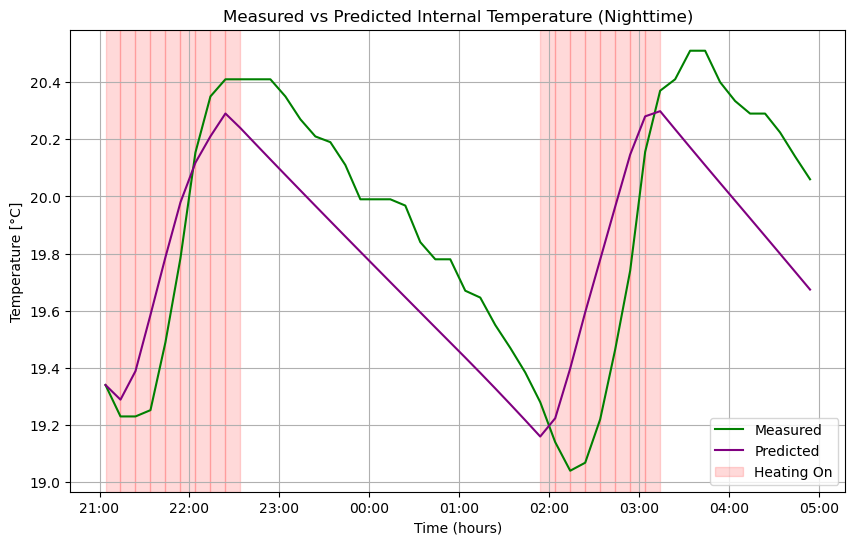

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  

# Load data from the CSV file
file_path = "Property_ID=EOH3151.csv"
data = pd.read_csv(file_path)

# Convert Timestamp to datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Filter relevant columns
data = data[['Timestamp', 'External_Air_Temperature', 'Internal_Air_Temperature', 'Heat_Pump_Energy_Output']]

# Assign provided values of R and C
R = 9.2237  # °C/kW
C = 3.7046  # kWh/°C

# Calculate time difference in seconds
data['Time_Diff'] = data['Timestamp'].diff().dt.total_seconds()

# Calculate incremental heat pump energy in kW
data['Heat_Pump_Energy_Incremental'] = data['Heat_Pump_Energy_Output'].diff()
data['Heat_Pump_Energy_Incremental_kW'] = data['Heat_Pump_Energy_Output'].diff() / (data['Time_Diff'] / 3600)

# Group data into 10-minute intervals (averaging every 5 intervals of 2 minutes)
grouped_data = []
i = 0

while i < len(data) - 4:
    avg_row = data.iloc[i:i+5].mean()
    avg_row['Timestamp'] = data['Timestamp'].iloc[i+4]
    grouped_data.append(avg_row)
    i += 5

aggregated_data = pd.DataFrame(grouped_data)

# Recalculate the time difference in seconds
aggregated_data['Time_Diff'] = aggregated_data['Timestamp'].diff().dt.total_seconds()

# Filter data for the specific range
start_time = pd.to_datetime('2022-1-1 21:00:00')
end_time = pd.to_datetime('2022-1-2 05:00:00')
specific_data = aggregated_data[(aggregated_data['Timestamp'] >= start_time) & (aggregated_data['Timestamp'] <= end_time)].copy()

# Initialize the predicted temperature column
specific_data.loc[:, 'Predicted_Internal_Temperature'] = np.nan
specific_data.loc[specific_data.index[0], 'Predicted_Internal_Temperature'] = specific_data['Internal_Air_Temperature'].iloc[0]

# Calculate predicted internal temperature following the established logic
for i in range(1, len(specific_data)):
    time_diff = specific_data['Time_Diff'].iloc[i] / 3600.0  # in hours
    if time_diff <= 20 / 60 and time_diff > 0:  # If the time difference is less than or equal to 20 minutes and greater than 0
        T_in_prev = specific_data['Predicted_Internal_Temperature'].iloc[i-1]
        T_out = specific_data['External_Air_Temperature'].iloc[i]
        Q = specific_data['Heat_Pump_Energy_Incremental_kW'].iloc[i]
        
        # Apply the thermal equation
        dT_in_dt = ((T_out - T_in_prev) / (R*C)) + (Q / C)
        T_in_new = T_in_prev + dT_in_dt * time_diff
        specific_data.loc[specific_data.index[i], 'Predicted_Internal_Temperature'] = T_in_new

# Plot the results
plt.figure(figsize=(10, 6))

# Plot measured and predicted temperatures
plt.plot(specific_data['Timestamp'], specific_data['Internal_Air_Temperature'], label='Measured', color='green')
plt.plot(specific_data['Timestamp'], specific_data['Predicted_Internal_Temperature'], label='Predicted', color='purple')  # Changed to purple

# Shade areas where Q is not equal to 0 with a softer color
for i in range(1, len(specific_data)):
    if specific_data['Heat_Pump_Energy_Incremental_kW'].iloc[i] != 0:
        plt.axvspan(specific_data['Timestamp'].iloc[i-1], specific_data['Timestamp'].iloc[i], color='red', alpha=0.15, label='Heating On')  # Lower alpha for softer color

# Ensure 'Heating On' label does not repeat in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Format the X-axis to show only hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())

plt.xlabel('Time (hours)')
plt.ylabel('Temperature [°C]')
plt.title('Measured vs Predicted Internal Temperature (Nighttime)')
plt.grid(True)

# Save the plot to a PDF called Validation.pdf
plt.savefig('Validation_with_light_heating.pdf')

plt.show()


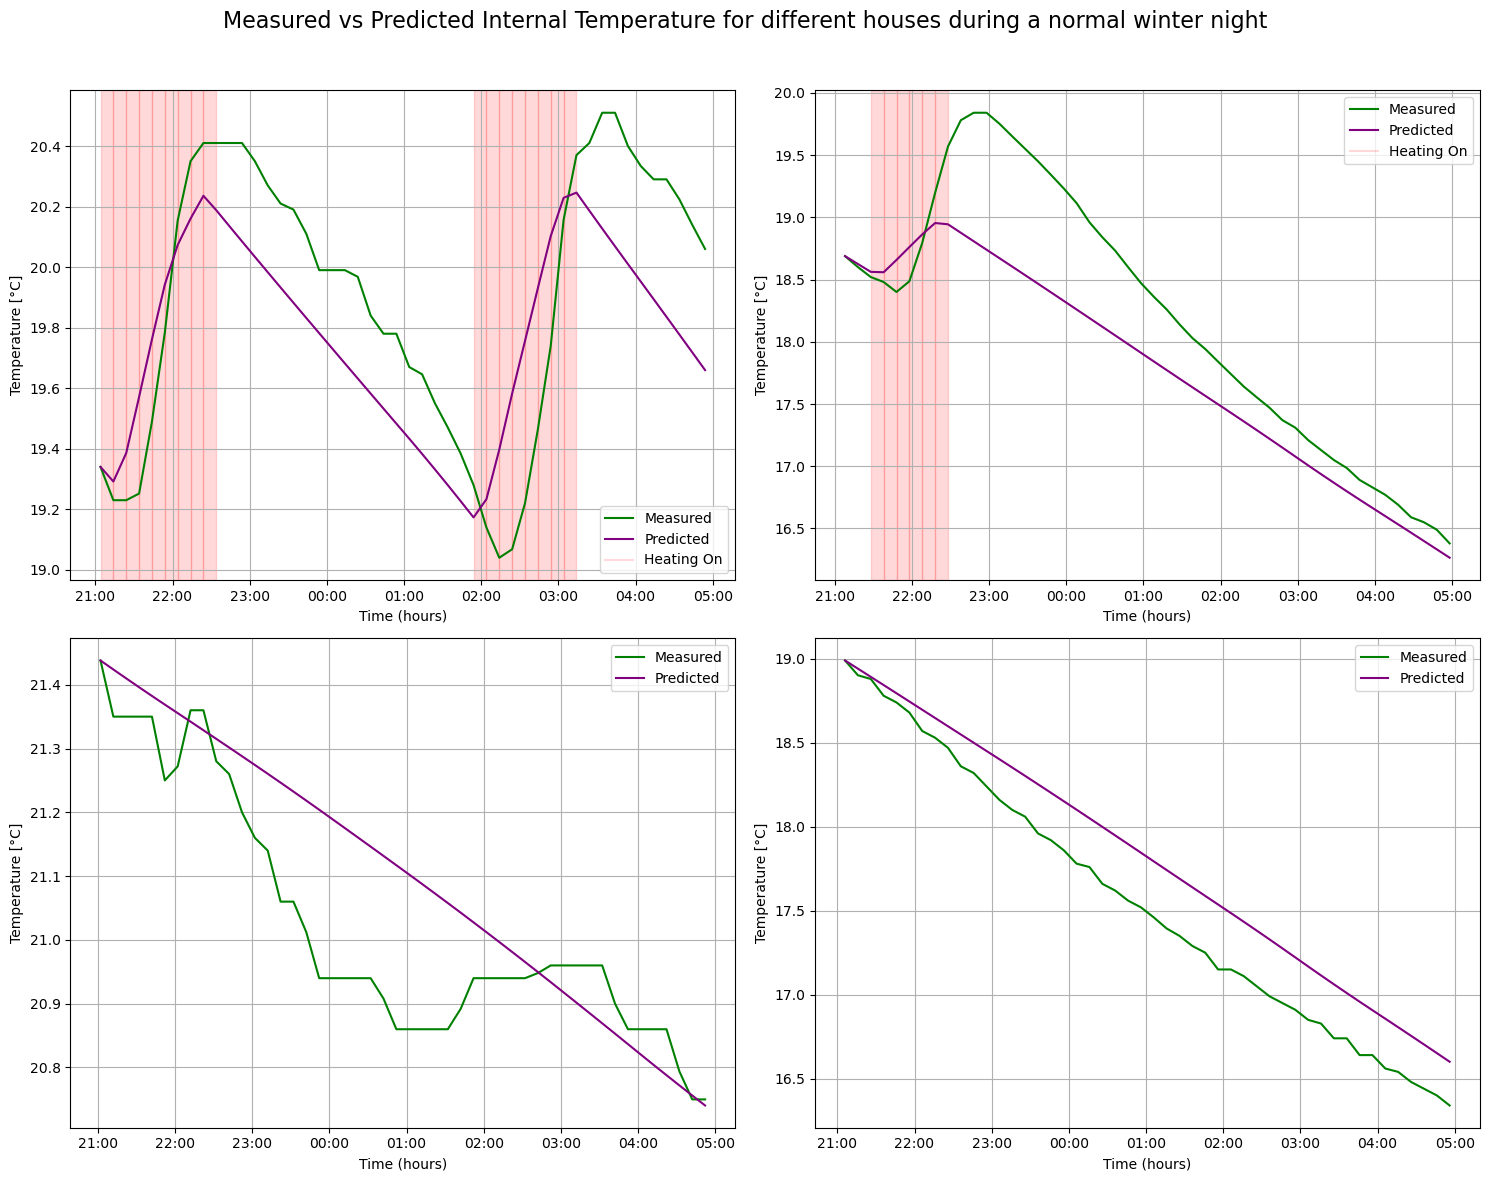

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  

# Define a list of configurations for each subplot
configs = [
    {"file_path": "Property_ID=EOH3151.csv", "R": 9.2237, "C": 3.9336, "title": "EOH3151"},
    {"file_path": "Property_ID=EOH2609.csv", "R": 2.5712, "C": 9.4218, "title": "EOH2609"},
    {"file_path": "Property_ID=EOH0248.csv", "R": 3.2013, "C": 45.5187, "title": "EOH0248"},
    {"file_path": "Property_ID=EOH1062.csv", "R": 6.6866, "C": 4.8505, "title": "EOH1062"}
]

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Iterate over each configuration and subplot
for i, config in enumerate(configs):
    # Load data from the CSV file
    data = pd.read_csv(config["file_path"])

    # Convert Timestamp to datetime format
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])

    # Filter relevant columns
    data = data[['Timestamp', 'External_Air_Temperature', 'Internal_Air_Temperature', 'Heat_Pump_Energy_Output']]

    # Assign provided values of R and C
    R = config["R"]  # °C/kW
    C = config["C"]  # kWh/°C

    # Calculate time difference in seconds
    data['Time_Diff'] = data['Timestamp'].diff().dt.total_seconds()

    # Calculate incremental heat pump energy in kW
    data['Heat_Pump_Energy_Incremental'] = data['Heat_Pump_Energy_Output'].diff()
    data['Heat_Pump_Energy_Incremental_kW'] = data['Heat_Pump_Energy_Output'].diff() / (data['Time_Diff'] / 3600)

    # Group data into 10-minute intervals (averaging every 5 intervals of 2 minutes)
    grouped_data = []
    j = 0

    while j < len(data) - 4:
        avg_row = data.iloc[j:j+5].mean()
        avg_row['Timestamp'] = data['Timestamp'].iloc[j+4]
        grouped_data.append(avg_row)
        j += 5

    aggregated_data = pd.DataFrame(grouped_data)

    # Recalculate the time difference in seconds
    aggregated_data['Time_Diff'] = aggregated_data['Timestamp'].diff().dt.total_seconds()

    # Filter data for the specific range
    start_time = pd.to_datetime('2022-1-1 21:00:00')
    end_time = pd.to_datetime('2022-1-2 05:00:00')
    specific_data = aggregated_data[(aggregated_data['Timestamp'] >= start_time) & (aggregated_data['Timestamp'] <= end_time)].copy()

    # Initialize the predicted temperature column
    specific_data.loc[:, 'Predicted_Internal_Temperature'] = np.nan
    specific_data.loc[specific_data.index[0], 'Predicted_Internal_Temperature'] = specific_data['Internal_Air_Temperature'].iloc[0]

    # Calculate predicted internal temperature following the established logic
    for k in range(1, len(specific_data)):
        time_diff = specific_data['Time_Diff'].iloc[k] / 3600.0  # in hours
        if time_diff <= 20 / 60 and time_diff > 0:  # If the time difference is less than or equal to 20 minutes and greater than 0
            T_in_prev = specific_data['Predicted_Internal_Temperature'].iloc[k-1]
            T_out = specific_data['External_Air_Temperature'].iloc[k]
            Q = specific_data['Heat_Pump_Energy_Incremental_kW'].iloc[k]
            
            # Apply the thermal equation
            dT_in_dt = ((T_out - T_in_prev) / (R*C)) + (Q / C)
            T_in_new = T_in_prev + dT_in_dt * time_diff
            specific_data.loc[specific_data.index[k], 'Predicted_Internal_Temperature'] = T_in_new

    # Determine the current subplot
    ax = axs[i]

    # Plot measured and predicted temperatures
    ax.plot(specific_data['Timestamp'], specific_data['Internal_Air_Temperature'], label='Measured', color='green')
    ax.plot(specific_data['Timestamp'], specific_data['Predicted_Internal_Temperature'], label='Predicted', color='purple')

    # Shade areas where Q is not equal to 0 with a softer color
    heating_on = False
    for k in range(1, len(specific_data)):
        if specific_data['Heat_Pump_Energy_Incremental_kW'].iloc[k] != 0:
            ax.axvspan(specific_data['Timestamp'].iloc[k-1], specific_data['Timestamp'].iloc[k], color='red', alpha=0.15)
            heating_on = True

    # Manually add the 'Heating On' label if any heating period exists
    if heating_on:
        ax.plot([], [], color='red', alpha=0.15, label='Heating On')

    # Format the X-axis to show only hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator())

    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Temperature [°C]')
    ax.grid(True)
    
    # Add the legend inside each subplot
    ax.legend()

# Set the main title for the entire figure
fig.suptitle('Measured vs Predicted Internal Temperature for different houses during a normal winter night', fontsize=16)

# Adjust layout to prevent overlap with the title
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the plot to a PDF called Validation.pdf
plt.savefig('Validation_subplots_with_legends.pdf')

plt.show()
